(2644, 4)
(211224, 16)
timestamp         0
value             0
classification    0
date              0
dtype: int64
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64
Duplicates: 0


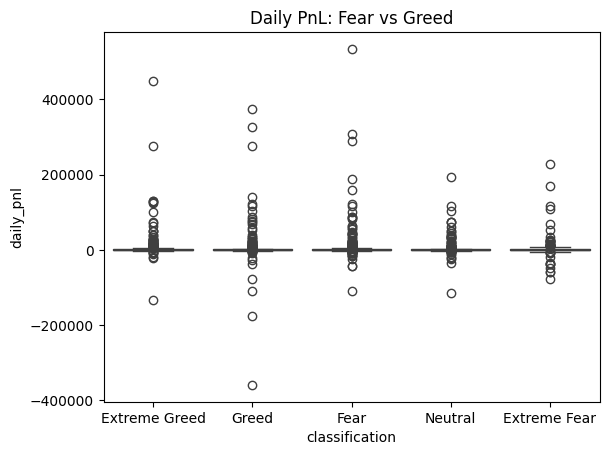

Accuracy: 0.7713675213675214


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Load data
sentiment = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")

# Inspect
print(sentiment.shape)
print(trades.shape)

print(sentiment.isnull().sum())
print(trades.isnull().sum())
print("Duplicates:", trades.duplicated().sum())

# Convert timestamps
trades['Timestamp IST'] = pd.to_datetime(trades['Timestamp IST'], format="%d-%m-%Y %H:%M")
trades['date'] = trades['Timestamp IST'].dt.date

sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date

# Merge
merged = trades.merge(sentiment, on='date', how='inner')

# Feature engineering
merged['is_win'] = merged['Closed PnL'] > 0

daily_metrics = merged.groupby(['Account', 'date', 'classification']).agg(
    daily_pnl=('Closed PnL', 'sum'),
    trades=('Closed PnL', 'count'),
    win_rate=('is_win', 'mean'),
    avg_size=('Size USD', 'mean'),
    long_ratio=('Side', lambda x: (x == 'BUY').mean())
).reset_index()

# Plot
sns.boxplot(data=daily_metrics, x='classification', y='daily_pnl')
plt.title("Daily PnL: Fear vs Greed")
plt.show()

# ML Model
daily_metrics['profit_bucket'] = (daily_metrics['daily_pnl'] > 0).astype(int)

X = daily_metrics[['trades', 'avg_size', 'long_ratio']]
y = daily_metrics['profit_bucket']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

print("Accuracy:", model.score(X_test, y_test))
importances = model.feature_importances_
feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)